In [1]:
%reset

In [2]:
import sys
sys.path.append('/home/users/ids29/DGRB')

In [3]:
import aegis
import numpy as np
import torch
import healpy as hp
import pickle as pk
from astropy import units
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
from sbi.inference import SNLE, SNPE#, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
# from sbi.inference.base import infer
from getdist import plots, MCSamples
from joblib import Parallel, delayed, parallel_backend
from scipy.integrate import quad, simpson
from scipy.interpolate import interp1d
import pickle
from scipy.stats import norm
import sources.DMsignal as DMsignal
import sources.FermiBackgrounds as FermiBackgrounds
from astropy import units as u


%matplotlib inline

In [4]:
grains=1000
num_workers = 48

In [5]:
energy_range = [1_000, 100_000] #MeV 
max_radius = 220 #kpc #This is the virial radius of the Milky Way
exposure = 2_000*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
angular_cut_degrees = 180 #degrees # 180 degress is full sky
lat_cut_degrees = 0 #degrees # 0 degrees is full sky
luminosity_range = np.array([1e13, 1e53]) # Minimum value set by considering source at distnace of closest approach by line of sight at 40 degrees and receiving 0.1 photon at detector side. CHANGE THIS FOR FINAL PROBLEM.
                                            # Maximum value set by that value of luminosity that suffieciently suppreses the luminoisity function at the higher end of the luminosity range.


parameter_range_aegis = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*1.5]
angular_cut = angular_cut_degrees*u.deg.to('rad') # radians
angular_cut_gen =  min(angular_cut*1.5, np.pi) # radians
lat_cut = lat_cut_degrees*u.deg.to('rad') # radians
lat_cut_gen = lat_cut*0.5 # radians

Isotropic background

In [ ]:
# Using the function: get_mean_isotropic_flux()

# # Note: Terminology:
# # flux is photon/cm^2/s
# # differential flux is photon/cm^2/s/MeV

# data_root = '/home/users/ids29/DGRB'
# fb = FermiBackgrounds.FermiBackgrounds(data_root)

# dF_sr = fb.get_mean_isotropic_flux(energy_range[0], energy_range[1]) # scalar # flux per solid angle. units: photon/cm^2/s/sr , across all pixels
# print(f"dF_sr = {dF_sr}")

# #  Find total number of photons in isotropic background for the full sky in the energy range given by 'energy_range'
# total_flux = dF_sr * 4*np.pi  # scalar # flux. units: photon/cm^2/s

# exposure_cm2_yr = exposure * (u.cm**2 * u.yr) #cm^2 yr
# exposure_cm2_s = exposure_cm2_yr.to(u.cm**2 * u.s)
# total_photons_iso_bg = total_flux * exposure_cm2_s.value
# print(f"Total number of photons in the isotropic background for the full sky in the energy range [{energy_range[0]/1e3}, {energy_range[1]/1e3}] GeV = {total_photons_iso_bg}")

dF_sr = 5.003264446734353e-07
Total number of photons in the isotropic background for the full sky in the energy range [1.0, 100.0] GeV = 793646.8200706702


In [ ]:
# Using the function: get_isotropic_background_spectrum_func()

# # Note: Terminology:
# # flux is photon/cm^2/s ; F = dN/dt/dA

data_root = '/home/users/ids29/DGRB'
fb = FermiBackgrounds.FermiBackgrounds(data_root)

dFdEdSr_E_interpfunc = fb.get_isotropic_background_spectrum_func() # returns an interpolation function -> dF/dE/d(solid_angle) versus E ; units: photon / cm^2 / s / MeV / sr

Es = np.geomspace(energy_range[0], energy_range[1], 10_001) # MeV
dFdEdSr = dFdEdSr_E_interpfunc(Es) # units: photon/cm^2/s/MeV/sr
dFdSr = simpson(dFdEdSr, x=Es) # units: photon/cm^2/s/sr

exposure_cm2_yr = exposure * (u.cm**2 * u.yr) #cm^2 yr
exposure_cm2_s = exposure_cm2_yr.to(u.cm**2 * u.s) # cm^2 s
total_photons_iso_bg = 4*np.pi * exposure_cm2_s.value * dFdSr # units: photon
print(f"Total number of photons in the isotropic background for the full sky in the energy range [{energy_range[0]/1e3}, {energy_range[1]/1e3}] GeV = {total_photons_iso_bg}")

Total number of photons in the isotropic background for the full sky in the energy range [1.0, 100.0] GeV = 793206.9993942769


Generate Spectrum (unnormalized) of isotropic background (no PSF, energy dispersion, etc. involved)

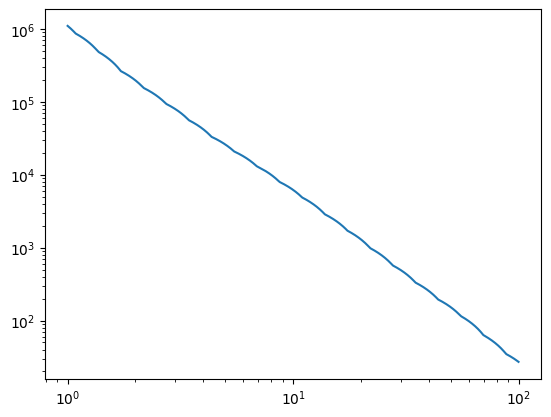

In [ ]:
# unnormalized spectrum -> dN/dE

data_root = '/home/users/ids29/DGRB'
fb = FermiBackgrounds.FermiBackgrounds(data_root)

dFdEdSr_E_interpfunc = fb.get_isotropic_background_spectrum_func() # returns an interpolation function -> dF/dE/d(solid_angle) versus E ; units: photon / cm^2 / s / MeV / sr

exposure_cm2_yr = exposure * (u.cm**2 * u.yr) #cm^2 yr
exposure_cm2_s = exposure_cm2_yr.to(u.cm**2 * u.s) # cm^2 s

# Create spectrum as a function of energy
dNdE_MeV_interpfunc = lambda E_MeV: dFdEdSr_E_interpfunc(E_MeV) * exposure_cm2_s.value * 4*np.pi  # photon / MeV

Es_MeV = np.geomspace(energy_range[0], energy_range[1], 1_000) # MeV
Es_GeV = Es_MeV / 1e3 # GeV

dNdE_MeV = dNdE_MeV_interpfunc(Es_MeV) # photon / MeV
dNdE_GeV = 1e3 * dNdE_MeV # photon / GeV

plt.loglog(Es_GeV, dNdE_GeV)

plt.show()


In [12]:
np.save('bin_edges_E_GeV.npy', Es_GeV)
np.save('spectrum_dNdE_GeV.npy', dNdE_GeV)

Anisotropic Background

In [ ]:
# Note: Terminology:
# flux is photon/cm^2/s
# differential flux is photon/cm^2/s/MeV

N_side = 64
data_root = '/home/users/ids29/DGRB'
fb = FermiBackgrounds.FermiBackgrounds(data_root)
aniso_bg_dict = fb.get_nonistropic_background(N_side=N_side)

E_MeV = aniso_bg_dict["energies_MeV"]       # shape (N_E,)
dF_dE_sr = aniso_bg_dict["galactic_bg"]      # shape (N_E, N_pix) # differential flux per solid angle in units: photons/cm^2/s/sr/MeV
print(f"E_MeV = {E_MeV} MeV")

print(f"E_MeV.shape = {E_MeV.shape}; dF_dE_sr.shape = {dF_dE_sr.shape}")

# Create interpolation function of dF_dE_sr versus E_MeV. Inteprolation is along energy axis
func_interp = interp1d(E_MeV, dF_dE_sr, kind="linear", axis=0, bounds_error=True)


# INtegrate dF_dE_sr wrt E_MeV using Simpson's rule: integration along the energy axis
num_points = 10_001
E_simps = np.geomspace(energy_range[0], energy_range[1], num_points)
dF_dE_sr_simps = func_interp(E_simps)  # shape = (num_points, N_pix)
print(f"dF_dE_sr_simps.shape = {dF_dE_sr_simps.shape}")
dF_sr = simpson(dF_dE_sr_simps, x=E_simps, axis=0)  # shape(N_pix,)  # flux per solid angle in units: photon/cm^2/s/sr
print(f"dF_sr.shape = {dF_sr.shape}")

# Find total number of photons in anisotropic background for the full sky in the eenrgy range given by 'energy_range'
N_pix = dF_sr.size # total number of pixels
Omega_pix  = 4*np.pi / N_pix # solid angle for 1 pixel
F = dF_sr * Omega_pix # shape (N_pix,) # flux in units: photon/cm^2/s
print(f"F.shape = {F.shape}")
total_flux = F.sum() # scalar 

exposure_cm2_yr = exposure * (u.cm**2 * u.yr) #cm^2 yr
exposure_cm2_s = exposure_cm2_yr.to(u.cm**2 * u.s)
total_photons_aniso_bg = total_flux * exposure_cm2_s.value
print(f"Total number of photons in the anisotropic background for the full sky in the energy range [{energy_range[0]/1e3}, {energy_range[1]/1e3}] GeV = {total_photons_aniso_bg}")

E_MeV = [5.00000000e+01 6.49828300e+01 8.44553639e+01 1.09762971e+02
 1.42654170e+02 1.85401433e+02 2.40958196e+02 3.13162910e+02
 4.07004243e+02 5.28965751e+02 6.87473830e+02 8.93479900e+02
 1.16121705e+03 1.50918340e+03 1.96142017e+03 2.54917267e+03
 3.31304908e+03 4.30582611e+03 7.27300221e+03 1.22848810e+04
 2.07504819e+04 3.50497899e+04 5.92028552e+04 9.99999737e+04
 1.68910683e+05 2.85308264e+05 4.81916266e+05 8.14008272e+05] MeV
E_MeV.shape = (28,); dF_dE_sr.shape = (28, 49152)
dF_dE_sr_simps.shape = (10001, 49152)
dF_sr.shape = (49152,)
F.shape = (49152,)
Total number of photons in the anisotropic background for the full sky in the energy range [1.0, 100.0] GeV = 6463318.728490736


Compute average number of photons-in-a-pixel, considering both isotropic & anisotropic backgrounds, for the full sky

In [19]:
total_photons = total_photons_iso_bg + total_photons_aniso_bg
N_side = 64
N_pix = 12*N_side**2
avg_photons_in_a_pixel = total_photons / N_pix
print(f"Average number of photons-in-a-pixel (N_side = {N_side}), considering both isotropic & anisotropic backgrounds, for the full sky = {avg_photons_in_a_pixel}")

Average number of photons-in-a-pixel (N_side = 64), considering both isotropic & anisotropic backgrounds, for the full sky = 147.64334205243748
